<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [4]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,xgboost

Ethen 2018-10-09 15:55:30 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.1
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2
xgboost 0.7


In [1]:
# https://towardsdatascience.com/xgboost-deployment-made-easy-6e11f4b3f817
train = pd.read_csv("all/train.csv")
test = pd.read_csv("all/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
X_y_train = xgb.DMatrix(data=train[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']], 
                        label=train['Survived'])
X_test = xgb.DMatrix(data=test[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']])

params = {
          'base_score': np.mean(train['Survived']),
          'eta': 0.1,
          'max_depth': 3,
          'gamma' :3,
          'objective'   :'reg:linear',
          'eval_metric' :'mae'
         }
model = xgb.train(params=params, 
                  dtrain=X_y_train, 
                  num_boost_round=3)
model

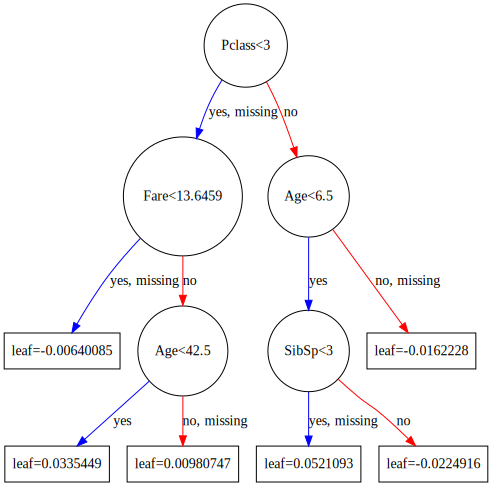

In [8]:
xgb.to_graphviz(model,num_trees=0)

In [9]:
model_dump = model.get_dump()
print('num trees: ', len(model_dump))
model_dump[0]

num trees:  3


'0:[Pclass<3] yes=1,no=2,missing=1\n\t1:[Fare<13.6459] yes=3,no=4,missing=3\n\t\t3:leaf=-0.00640085\n\t\t4:[Age<42.5] yes=9,no=10,missing=10\n\t\t\t9:leaf=0.0335449\n\t\t\t10:leaf=0.00980747\n\t2:[Age<6.5] yes=5,no=6,missing=6\n\t\t5:[SibSp<3] yes=11,no=12,missing=11\n\t\t\t11:leaf=0.0521093\n\t\t\t12:leaf=-0.0224916\n\t\t6:leaf=-0.0162228\n'

In [11]:
tree = model_dump[0]
splitted = tree.split('\n')
splitted

['0:[Pclass<3] yes=1,no=2,missing=1',
 '\t1:[Fare<13.6459] yes=3,no=4,missing=3',
 '\t\t3:leaf=-0.00640085',
 '\t\t4:[Age<42.5] yes=9,no=10,missing=10',
 '\t\t\t9:leaf=0.0335449',
 '\t\t\t10:leaf=0.00980747',
 '\t2:[Age<6.5] yes=5,no=6,missing=6',
 '\t\t5:[SibSp<3] yes=11,no=12,missing=11',
 '\t\t\t11:leaf=0.0521093',
 '\t\t\t12:leaf=-0.0224916',
 '\t\t6:leaf=-0.0162228',
 '']

In [5]:
def string_parser(s):
    if len(re.findall(r":leaf=", s)) == 0:
        out  = re.findall(r"[\w.-]+", s)
        tabs = re.findall(r"[\t]+", s)
        if (out[4] == out[8]):
            missing_value_handling = (" or np.isnan(x['" + out[1] + "']) ")
        else:
            missing_value_handling = ""
            
        if len(tabs) > 0:
            return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                    '        if state == ' + out[0] + ':\n' +
                    re.findall(r"[\t]+", s)[0].replace('\t', '    ') +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling + 
                    ' else ' + out[6] + ')\n' )

        else:
            return ('        if state == ' + out[0] + ':\n' +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling +
                    ' else ' + out[6] + ')\n' )
    else:
        out = re.findall(r"[\d.-]+", s)
        return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        if state == ' + out[0] + ':\n    ' +
                re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        return ' + out[1] + '\n')
      
def tree_parser(tree, i):
    if i == 0:
        return ('    if num_booster == 0:\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) 
                        for i in range(len(tree.split('\n'))-1)]))
    else:
        return ('    elif num_booster == '+str(i)+':\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) 
                        for i in range(len(tree.split('\n'))-1)])) 
    
def model_to_py(base_score, model, out_file):
    trees = model.get_dump()
    result = ["import numpy as np\n\n" 
             +"def xgb_tree(x, num_booster):\n"]
    
    for i in range(len(trees)):
        result.append(tree_parser(trees[i], i))
    
    with open(out_file, 'a') as the_file:
        the_file.write("".join(result) + "\ndef xgb_predict(x):\n    predict = " 
                       + str(base_score) + "\n"
                       + "# initialize prediction with base score\n" 
                       + "    for i in range(" 
                       + str(len(trees))  
                       + "):\n        predict = predict + xgb_tree(x, i)"
                       + "\n    return predict")

In [12]:
model_to_py(params['base_score'], model, 'xgb_model.py')

In [17]:
import xgb_model

data1 = {'Pclass': 3, 'Age': 34.5, 'Fare': 7.8292, 'SibSp': 0, 'Parch': 0}
xgb_model.xgb_predict(data1)

0.34158018383838384

In [18]:
data1 = {'Pclass': 2, 'Age': 62.0, 'Fare': 9.6875, 'SibSp': 0, 'Parch': 0}
xgb_model.xgb_predict(data1)

0.3717296318383838

In [16]:
prediction = model.predict(X_test)
test['pred'] = prediction
test[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'pred']].head(3)

,Pclass,Age,Fare,SibSp,Parch,pred
0,3,34.5,7.8292,0,0,0.34158
1,3,47.0,7.0000,1,0,0.34158
2,2,62.0,9.6875,0,0,0.37173
